# Detecting Anomalies with an Autoencoder

The ECG dataset which contains 4998 examples of electrocardiogram (ECG) signals.

This notebook provides you with a complete code example that detects anomalies in ECGs using the latent space generated by an autoencoder.

## Loading the ECG Dataset

Load the ECG dataset ...

In [1]:
import deeptrack as dt
import pandas as pd
import torch

dataframe = pd.read_csv("ecg.csv", header=None)
raw_data = dataframe.values
ecgs = raw_data[:, 2:-11]
labels = raw_data[:, -1].astype(bool)

sources = dt.sources.Source(ecg=ecgs, is_normal=labels)
train_sources, test_sources = dt.sources.random_split(sources, [0.7, 0.3])
normal_sources = train_sources.filter(lambda ecg, is_normal: is_normal)

print(f"raw_data.shape = {raw_data.shape}")
print(f"Train ECGs = {len(train_sources)}")
print(f"Normal train ECGs = {len(normal_sources)}")

raw_data.shape = (4998, 141)
Number of train ECGs = 3499
Number of normal train ECGs = 2037


... and plot some normal ECG traces.

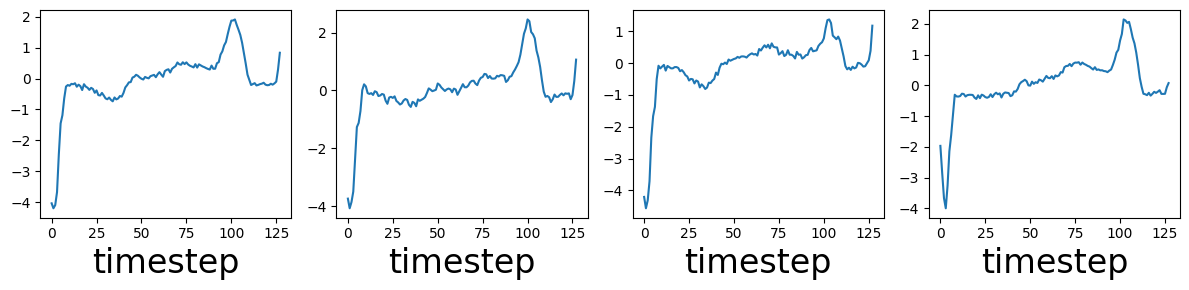

In [33]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(1, 4, figsize=((12, 3)))
for idx, ax in enumerate(axs.ravel()):
    ecg = normal_sources[idx]["ecg"]
    ax.plot(ecg)
    ax.set_xlabel("timestep", fontsize=24)
fig.tight_layout()
plt.show()

## Normalizing the ECG Traces
 
Normalize the ECGs based on the normal range ...

In [6]:
import numpy as np

min_normal = np.min([source["ecg"] for source in normal_sources])
max_normal = np.max([source["ecg"] for source in normal_sources])

ecg_pip = dt.Value(sources.ecg - min_normal) / (max_normal - min_normal) \
    >> dt.Unsqueeze(axis=0) >> dt.pytorch.ToTensor(dtype=torch.float)
label_pip = dt.Value(sources.is_normal)

... and plot them again.

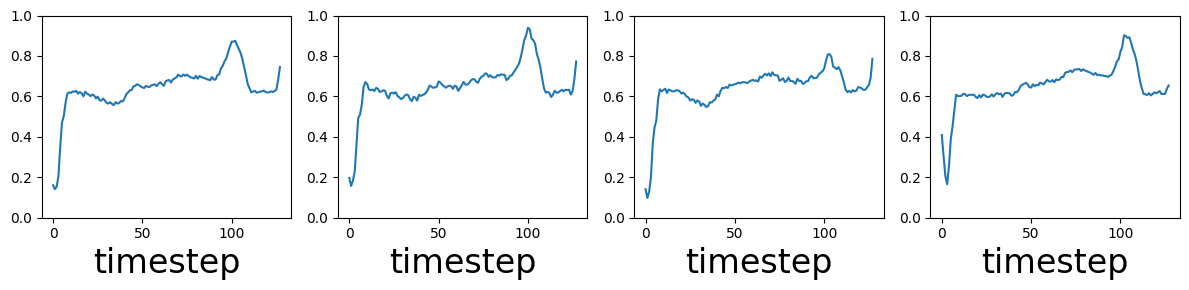

In [32]:
fig, axs = plt.subplots(1, 4, figsize=((12, 3)))
for idx, ax in enumerate(axs.ravel()):
    ecg = ecg_pip(normal_sources[idx])
    ax.plot(ecg.squeeze())
    ax.set_ylim([0, 1])
    ax.set_xlabel("timestep", fontsize=24)
fig.tight_layout()
plt.show()

## Defining and Training the Autoencoder

Define an autoencoder for 1D data ...

In [12]:
import deeplay as dl
import torch.nn as nn

autoencoder = dl.ConvolutionalEncoderDecoder2d(in_channels=1, 
    encoder_channels=[8, 8], out_channels=1, out_activation=nn.Identity)
autoencoder[..., "layer"].configure(nn.Conv1d, kernel_size=4, padding="same")
autoencoder[..., "pool"].configure(nn.MaxPool1d, kernel_size=4, stride=4)
autoencoder[..., "upsample"].configure(nn.ConvTranspose1d, kernel_size=4, 
                                        stride=4)

print(autoencoder)

ConvolutionalEncoderDecoder2d(
  (encoder): ConvolutionalEncoder2d(
    (blocks): LayerList(
      (0): Conv2dBlock(
        (layer): Layer[Conv1d](in_channels=1, out_channels=8, kernel_size=4, stride=1, padding=same)
        (activation): Layer[ReLU]()
      )
      (1): Conv2dBlock(
        (pool): Layer[MaxPool1d](kernel_size=4, stride=4)
        (layer): Layer[Conv1d](in_channels=8, out_channels=8, kernel_size=4, stride=1, padding=same)
        (activation): Layer[ReLU]()
      )
    )
    (postprocess): Layer[Identity]()
  )
  (bottleneck): ConvolutionalNeuralNetwork(
    (blocks): LayerList(
      (0): Conv2dBlock(
        (pool): Layer[MaxPool1d](kernel_size=4, stride=4)
        (layer): Layer[Conv1d](in_channels=8, out_channels=8, kernel_size=4, stride=1, padding=same)
        (activation): Layer[ReLU]()
        (upsample): Layer[ConvTranspose1d](kernel_size=4, stride=4, padding=0, in_channels=8, out_channels=8)
      )
    )
  )
  (decoder): ConvolutionalDecoder2d(
    (blocks

... define the autoencoder regressor ...

In [13]:
regressor_template = dl.Regressor(model=autoencoder, loss=nn.L1Loss(), 
                                  optimizer=dl.Adam())
ae = regressor_template.create()

print(ae)

Regressor(
  (loss): L1Loss()
  (train_metrics): MetricCollection,
    prefix=train
  )
  (val_metrics): MetricCollection,
    prefix=val
  )
  (test_metrics): MetricCollection,
    prefix=test
  )
  (model): ConvolutionalEncoderDecoder2d(
    (encoder): ConvolutionalEncoder2d(
      (blocks): LayerList(
        (0): Conv2dBlock(
          (layer): Conv1d(1, 8, kernel_size=(4,), stride=(1,), padding=same)
          (activation): ReLU()
        )
        (1): Conv2dBlock(
          (pool): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
          (layer): Conv1d(8, 8, kernel_size=(4,), stride=(1,), padding=same)
          (activation): ReLU()
        )
      )
      (postprocess): Identity()
    )
    (bottleneck): ConvolutionalNeuralNetwork(
      (blocks): LayerList(
        (0): Conv2dBlock(
          (pool): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
          (layer): Conv1d(8, 8, kernel_size=(4,), stride=(1,), padding=same

... define the data loader ...

In [14]:
train_dataset = dt.pytorch.Dataset(ecg_pip & ecg_pip, inputs=normal_sources)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16,
                                           shuffle=True)

... and train the autoencoder on the normal ECGs.

In [15]:
ae_trainer = dl.Trainer(max_epochs=30, accelerator="auto")
ae_trainer.fit(ae, train_loader)

/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_dlcc/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_dlcc/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name          ┃ Type                          ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ loss          │ L1Loss                        │      0 │
│ 1 │ train_metrics │ MetricCollection              │      0 │
│ 2 │ val_metrics   │ MetricCollection              │      0 │
│ 3 │ test_metrics  │ MetricCollection              │      0 │
│ 4 │ model         │ ConvolutionalEncoderDecoder2d │  1.4 K │
│ 5 │ optimizer     │ Adam                          │      0 │
└───┴───────────────┴───────────────────────────────┴────────┘

Trainable params: 1.4 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.4 K                                                                                                
Total estimated model params size (MB): 0

/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_dlcc/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Output()

/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_dlcc/lib/python3.12/site-packages/torch/nn/mod
ules/conv.py:306: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a 
zero-padded copy of the input be created (Triggered internally at 
/Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Convolution.cpp:1041.)
  return F.conv1d(input, weight, bias, self.stride,

## Testing the Trained Autoencoder with Normal and Anomalous ECGs

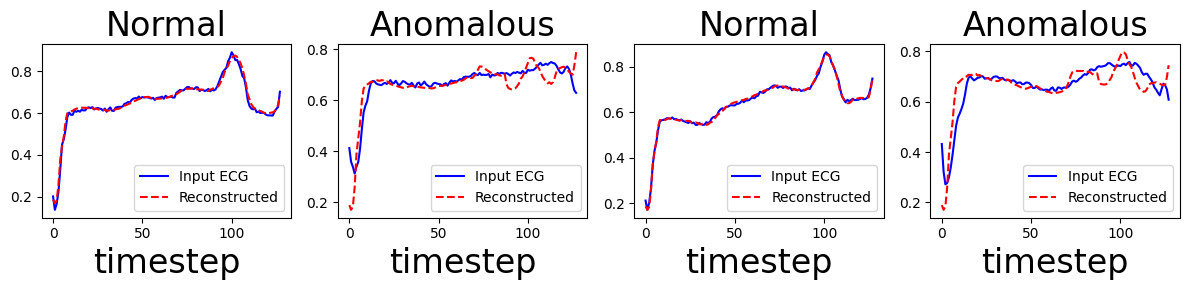

In [31]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(1, 4, figsize=((12, 3)))
for ax, source in zip(axs.ravel(), np.random.choice(test_sources, 4)):
    test_ecg, test_label = (ecg_pip & label_pip)(source)
    pred_ecg = ae(test_ecg.float().unsqueeze(0))
    ax.plot(test_ecg.squeeze(), c="b", label="Input ECG")
    ax.plot(pred_ecg.detach().squeeze(), c="r", ls="--", label="Reconstructed")
    ax.set_title("Normal" if test_label else "Anomalous", fontsize=24)
    ax.legend()
    ax.set_xlabel("timestep", fontsize=24)
fig.tight_layout()
plt.show()

## Detecting Anomalies from the Reconstruction Error

Determine and plot the normal reconstrution error ...

In [34]:
normal_train_ecgs = torch.stack([ecg_pip(source) for source in normal_sources])
normal_train_preds = ae(normal_train_ecgs).detach()
normal_train_losses = [nn.functional.l1_loss(ecg, pred) for ecg, pred 
                       in zip(normal_train_ecgs, normal_train_preds)]

threshold_losses = np.quantile(normal_train_losses, 0.95)

...  implement a function to plot the histogram highlighting the threshold ...

In [45]:
def hist(title, xlabel, values, threshold_label, threshold):
    """Plot the histogram highlighting the threshold."""
    plt.hist(values, bins=50, label=title)
    plt.axvline(x=threshold, color="k", linestyle=":", label=threshold_label)
    plt.xlabel(xlabel, fontsize=16)
    plt.ylabel("ECG Number", fontsize=16)
    plt.legend()
    plt.show()

... plot the normal reconstruction error ...

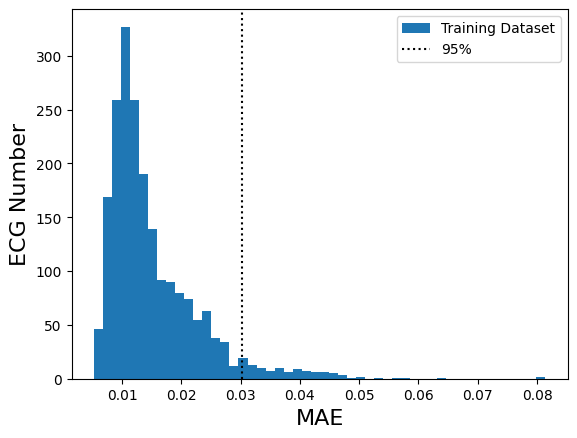

In [46]:
hist("Training Dataset", "MAE", normal_train_losses, "95%", threshold_losses)

... calculate and plot the reconstruction error in the test data.

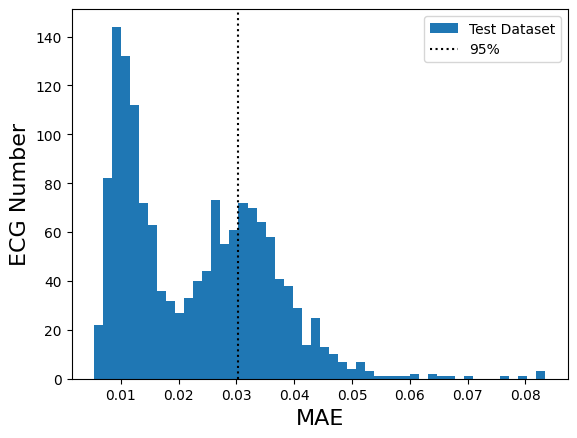

In [47]:
test_ecgs = torch.stack([ecg_pip(source) for source in test_sources])
test_preds = ae(test_ecgs).detach()
test_losses = [nn.functional.l1_loss(ecg, pred) for ecg, pred 
               in zip(test_ecgs, test_preds)]

hist("Test Dataset", "MAE", test_losses, "95%", threshold_losses)

... implement a function to determine the accuracy, precision, and recall of the performance
metric ...

In [48]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

def evaluate(labels, predictions):
    """Evaluate accuracy, precision, and recall of performance metric."""
    print(f"Accuracy = {accuracy_score(labels, predictions):.3f}  "
          + f"Precision = {precision_score(labels, predictions):.3f}  "
          + f"Recall = {recall_score(labels, predictions):.3f}")

... and determine the performance metrics for the anomaly detection based on the
reconstruction error.

In [49]:
evaluate(labels=[label_pip(source) for source in test_sources], 
         predictions=test_losses < threshold_losses)

Accuracy = 0.852  Precision = 0.823  Recall = 0.954


## Detecting Anomalies Using the Latent Space

Calculate the latent space values for the normal ECGs ...

In [50]:
latent_space_train = ae.model.encoder(normal_train_ecgs).detach()
latent_space_train = latent_space_train.view(latent_space_train.shape[0], -1)

... determine the distance between a representation in the latent sapce of a
normal ECG and its neighbors ...

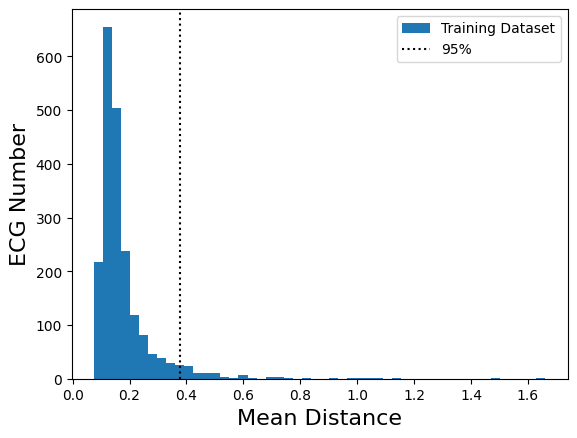

In [51]:
from sklearn.neighbors import NearestNeighbors

n_neighbors = 4  # Number of nearest neighbors.

neighbors = NearestNeighbors(n_neighbors=n_neighbors + 1, 
                             algorithm="ball_tree").fit(latent_space_train)
distances, _ = neighbors.kneighbors(latent_space_train)
distances = distances[:, 1:]
mean_distance = np.mean(distances, 1)

threshold_dist = np.quantile(mean_distance, 0.95)

hist("Training Dataset", "Mean Distance", mean_distance, "95%", threshold_dist)

... calculating the latent space values for the test ECGs ...

In [52]:
latent_space_test = ae.model.encoder(test_ecgs).detach()
latent_space_test = latent_space_test.view(latent_space_test.shape[0], -1)

... determine and plot the distance between the test ECGs and the closest normal ECGs ...

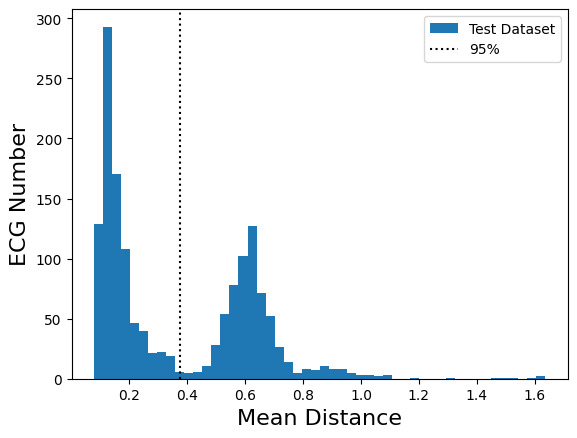

In [53]:
from sklearn.metrics import pairwise_distances

mean_dist_test = pairwise_distances(latent_space_test, latent_space_train)
mean_dist_test = np.mean(
    np.partition(mean_dist_test, n_neighbors, axis=1)[:, :n_neighbors], 1
)

hist("Test Dataset", "Mean Distance", mean_dist_test, "95%", threshold_dist)

... and determine the performance metrics for the anomaly detection based on the
latent space.

In [54]:
evaluate(labels=[label_pip(source) for source in test_sources],
         predictions=mean_dist_test < threshold_dist)

Accuracy = 0.976  Precision = 0.996  Recall = 0.963
